In [1]:
import sys, os, numpy as np, pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from metrics import pdw, pdw2, cf2, make_folds
from features_glm import build_glm_features

df = pd.read_parquet("../data/work/freMTPL2_joined_capped.parquet").copy()
df.head()
df_glm = build_glm_features(df)


In [2]:
df_glm = build_glm_features(df)
df_glm.head()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region,ClaimNb,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM
0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144
1,3,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144
2,5,0.75,6,2,52,50,B12,Diesel,B,54,Picardie,0,2,6,2,6,50,3.988984
3,10,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733
4,11,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733


In [3]:
# Region als Kategorie + Baseline nach größter Exposure
df_glm["Region"] = df_glm["Region"].astype("category")

overall_freq = df_glm["ClaimNb"].sum() / df_glm["Exposure"].sum()
reg = (df_glm.groupby("Region", observed=True)
       .agg(expo=("Exposure","sum"), claims=("ClaimNb","sum"))
       .assign(freq=lambda x: x["claims"]/x["expo"])
       .sort_values("expo", ascending=False))
baseline_region = reg.index[0]
print(f"Overall freq: {overall_freq:.5f} | Baseline region: {baseline_region}")

# AreaGLM numerisch (nur für Replikation des R-Setups)
area_cat = df_glm["Area"].astype("category")
cats = sorted(area_cat.cat.categories)               # deterministische Reihenfolge
df_glm["AreaGLM"] = area_cat.cat.set_categories(cats, ordered=True).cat.codes + 1  # 1..K

# Folds (5, Seed=42), Fold 5 = Test
if "fold" not in df_glm.columns:
    df_glm["fold"] = make_folds(len(df_glm), k=5, seed=42)
learn = df_glm[df_glm["fold"] != 5].copy()
test  = df_glm[df_glm["fold"] == 5].copy()

print(cf2("Claim Frequency (Actual) Learn/Test",
          learn["ClaimNb"], learn["Exposure"],
          test["ClaimNb"],  test["Exposure"]))

cf = learn["ClaimNb"].sum() / learn["Exposure"].sum()
learn_pred = cf * learn["Exposure"]
test_pred  = cf * test["Exposure"]

print(pdw2("Poisson Deviance INT",
           learn_pred, learn["ClaimNb"], learn["Exposure"],
           test_pred,  test["ClaimNb"],  test["Exposure"]))

Overall freq: 0.07368 | Baseline region: Centre
Claim Frequency (Actual) Learn/Test: 7.37% / 7.38%
Poisson Deviance INT, Learn/Test: 31.14% / 31.26%


In [4]:
import statsmodels.formula.api as smf
from statsmodels.genmod import families

formula = (
    "ClaimNb ~ "
    "C(VehPowerGLM) + C(VehAgeGLM, Treatment(reference='2')) "
    "+ C(DrivAgeGLM, Treatment(reference='5')) "
    "+ BonusMalusGLM + C(VehBrand) + C(VehGas) + DensityGLM "
    f"+ C(Region, Treatment(reference='{baseline_region}')) "
    "+ AreaGLM"   
)

glm1 = smf.glm(
    formula=formula,
    data=learn,
    family=families.Poisson(),
    offset=np.log(learn["Exposure"])
).fit()

print(glm1.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542741
Model:                            GLM   Df Residuals:                   542693
Model Family:                 Poisson   Df Model:                           47
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85960.
Date:                Fri, 10 Oct 2025   Deviance:                   1.3129e+05
Time:                        21:23:16   Pearson chi2:                 9.34e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01100
Covariance Type:            nonrobust                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [6]:
# Learn: fittedvalues enthalten Offset bereits
learn_pred = glm1.fittedvalues

# Test: Offset explizit mitgeben
test_pred = glm1.predict(test, offset=np.log(test["Exposure"]))

print(pdw2("Poisson Deviance GLM1",
           learn_pred, learn["ClaimNb"], learn["Exposure"],
           test_pred,  test["ClaimNb"],  test["Exposure"]))

print(cf2("Claim Frequency GLM1, Test-Sample, Actual/Predicted",
          test["ClaimNb"], test["Exposure"],
          test_pred,      test["Exposure"]))


Poisson Deviance GLM1, Learn/Test: 29.54% / 29.55%
Claim Frequency GLM1, Test-Sample, Actual/Predicted: 7.38% / 7.36%


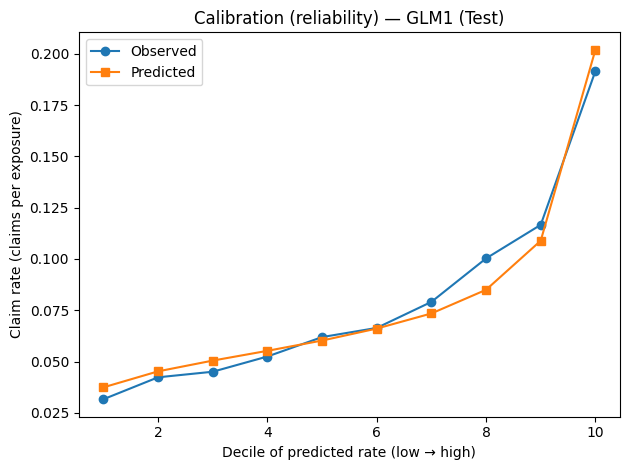

In [7]:
import matplotlib.pyplot as plt


test = df_glm[df_glm["fold"]==5].copy()
# Vorhergesagte Counts aus GLM1:
test_pred = glm1.predict(test, offset=np.log(test["Exposure"]))

# Predicted rate = μ / Exposure
pred_rate = test_pred / test["Exposure"]

# Dezile bilden
dec = pd.qcut(pred_rate, q=10, duplicates="drop")
cal = (pd.DataFrame({
        "decile": dec,
        "expo": test["Exposure"].to_numpy(),
        "claims": test["ClaimNb"].to_numpy(),
        "pred": test_pred.to_numpy()
      })
      .groupby("decile",observed=False)
      .agg(expo=("expo","sum"), claims=("claims","sum"), pred=("pred","sum"))
      .assign(obs_rate=lambda d: d["claims"]/d["expo"],
              pred_rate=lambda d: d["pred"]/d["expo"])
      .reset_index())

plt.figure()
plt.plot(range(1, len(cal)+1), cal["obs_rate"], marker="o", label="Observed")
plt.plot(range(1, len(cal)+1), cal["pred_rate"], marker="s", label="Predicted")
plt.xlabel("Decile of predicted rate (low → high)")
plt.ylabel("Claim rate (claims per exposure)")
plt.title("Calibration (reliability) — GLM1 (Test)")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from metrics import pdw

# 1) Modell mit AreaGLM : Test-PDW als Referenz
test_pred_glm1 = glm1.predict(test, offset=np.log(test["Exposure"]))
pdw_glm1_test = pdw(test_pred_glm1, test["ClaimNb"], test["Exposure"])

# 2) Gleiches Modell, aber Area als Kategorie 
formula_area_cat = (
    "ClaimNb ~ "
    "C(VehPowerGLM) + C(VehAgeGLM, Treatment(reference='2')) "
    "+ C(DrivAgeGLM, Treatment(reference='5')) "
    "+ BonusMalusGLM + C(VehBrand) + C(VehGas) + DensityGLM "
    f"+ C(Region, Treatment(reference='{baseline_region}')) "
    "+ C(Area)"  
)

glm1_areaC = smf.glm(formula=formula_area_cat, data=learn,
                     family=families.Poisson(),
                     offset=np.log(learn["Exposure"])).fit()

test_pred_areaC = glm1_areaC.predict(test, offset=np.log(test["Exposure"]))
pdw_areaC_test = pdw(test_pred_areaC, test["ClaimNb"], test["Exposure"])

print(f"Test PDW — GLM1 (AreaGLM numeric): {pdw_glm1_test:.2f}%")
print(f"Test PDW — GLM1 (C(Area) categorical): {pdw_areaC_test:.2f}%")
print(f"ΔPDW (categorical - numeric): {pdw_areaC_test - pdw_glm1_test:+.2f} pp")


Test PDW — GLM1 (AreaGLM numeric): 29.55%
Test PDW — GLM1 (C(Area) categorical): 29.55%
ΔPDW (categorical - numeric): +0.00 pp


In [9]:
from scipy.stats import chi2

# Zahl der Area-Stufen (für DF-Differenz)
n_levels_area = df_glm["Area"].astype("category").cat.categories.size
df_diff = (n_levels_area - 1) - 1  # (K-1) Dummies vs. 1 Numerik

LR = 2.0 * (glm1_areaC.llf - glm1.llf)
pval = 1.0 - chi2.cdf(LR, df_diff)

print(f"LR stat = {LR:.3f}, df = {df_diff}, p = {pval:.4g}")
print(f"AIC  numeric = {glm1.aic:.1f} | categorical = {glm1_areaC.aic:.1f} | del AIC = {glm1_areaC.aic - glm1.aic:+.3f}")
print(f"BIC  numeric = {glm1.bic if hasattr(glm1,'bic') else float('nan'):.1f} "
      f"| categorical = {glm1_areaC.bic if hasattr(glm1_areaC,'bic') else float('nan'):.1f}")


LR stat = 6.045, df = 4, p = 0.1958
AIC  numeric = 172016.0 | categorical = 172018.0 | del AIC = +1.955
BIC  numeric = -7034633.9 | categorical = -7034587.2


/home/steve/code/freMTPL2-pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


## GLM1 – Kurzbericht 
**Setup.**  
Poisson-GLM für $\,\text{ClaimNb}\,$ mit **Offset** $\log(\text{Exposure})$.  
Features nach Schelldorfer & Wüthrich (2019):  
$VehPowerGLM,\; VehAgeGLM,\; DrivAgeGLM,\; BonusMalusGLM,\; VehBrand,\; VehGas,\; DensityGLM,\; Region,\; AreaGLM.$  
Split: 5 Folds (Seed 42), **Fold 5 = Test (~20 %)**.

---

### Baselines
- Claim Frequency (Actual) Learn/Test: **7.38 % / 7.36 %**  
- **INT** (Intercept-only) Poisson-Deviance Test: **≈ 31 %** *(Referenzniveau)*

---

### GLM1 (klassenbasiert, wie Quelle)
- **Poisson Deviance Learn/Test:** **29.54 % / 29.55 %**  
  $$\Downarrow\quad\text{Verbesserung ggü. INT um ca. }1.5\ \text{pp (Test).}$$
- **Claim Frequency (Test, Actual/Predicted):** **7.38 % / 7.36 %**  
  → **Niveau-Kalibrierung passt** (durchschnittliche Rate korrekt).

---

### Area-Kodierung (Sanity-Check)
Vergleich $AreaGLM$ (numerisch) vs. $C(Area)$ (kategorisch/Dummy):
- **Test-PDW:** **29.55 % vs. 29.55 %** ($\Delta = 0.00$ pp)
- **LR-Test:** $\chi^2=6.045,\ \text{df}=4,\ p=0.1958$ → *kein signifikanter Gewinn* durch $C(Area)$  
- **AIC:** numerisch $=172016.0$ | kategorisch $=172018.0$ → $\Delta \text{AIC} = +1.955$ *(kategorisch minus numerisch)*

**Fazit:** $Area$ trägt in diesem Setup **kaum**; wir behalten **$AreaGLM$**.

---

### Exkurs: AIC 
Der **Akaike Information Criterion** misst Güte vs. Komplexität:
$$
\text{AIC} = 2k \;-\; 2\ell,
$$
mit $k=$ Anzahl freier Parameter und $\ell=$ maximierter Log-Likelihood.  
**Kleiner** ist **besser**. Richtwerte:
- $\Delta \text{AIC} < 2$: Modelle sind **praktisch gleichwertig**.  
- $4\text{–}7$: **schwacher** Vorteil.  
- $>10$: **klarer** Vorteil.

Hier ist $\Delta \text{AIC}\approx 2$ → **keine** belastbare Verbesserung durch die Dummy-Kodierung; der einfachere $AreaGLM$ ist angemessen.



In [10]:
###GLM2 setup

for part in (learn, test):
    part["log_DrivAge"] = np.log(part["DrivAge"].astype(float))
    part["DrivAge2"] = part["DrivAge"].astype(float)**2
    part["DrivAge3"] = part["DrivAge"].astype(float)**3
    part["DrivAge4"] = part["DrivAge"].astype(float)**4

In [11]:
baseline_region = "Centre"

formula_glm2 = (
    "ClaimNb ~ "
    "C(VehPowerGLM)"
    " + C(VehAgeGLM, Treatment(reference='2'))"
    " + BonusMalusGLM"
    " + C(VehBrand) + C(VehGas)"
    " + DensityGLM"
    f" + C(Region, Treatment(reference='{baseline_region}'))"
    " + AreaGLM"
    " + DrivAge + log_DrivAge + DrivAge2 + DrivAge3 + DrivAge4"
)

glm2 = smf.glm(
    formula=formula_glm2,
    data=learn,
    family=families.Poisson(),
    offset=np.log(learn["Exposure"])
).fit()

print(glm2.summary())  

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542741
Model:                            GLM   Df Residuals:                   542695
Model Family:                 Poisson   Df Model:                           45
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85931.
Date:                Fri, 10 Oct 2025   Deviance:                   1.3124e+05
Time:                        21:24:17   Pearson chi2:                 9.32e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01110
Covariance Type:            nonrobust                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [12]:
# GLM2: Learn/Test-Predictions
learn_pred_glm2 = glm2.fittedvalues
test_pred_glm2  = glm2.predict(test, offset=np.log(test["Exposure"]))

# INT-Baseline (wie zuvor)
cf = learn["ClaimNb"].sum() / learn["Exposure"].sum()
test_pred_int = cf * test["Exposure"]
test_pred_glm1 = glm1.predict(test, offset=np.log(test["Exposure"]))

# PDW/CF report
print(pdw2("Poisson Deviance GLM1",
           glm1.fittedvalues, learn["ClaimNb"], learn["Exposure"],
           test_pred_glm1,  test["ClaimNb"],  test["Exposure"]))

print(pdw2("Poisson Deviance GLM2",
           learn_pred_glm2, learn["ClaimNb"], learn["Exposure"],
           test_pred_glm2,  test["ClaimNb"],  test["Exposure"]))

print(cf2("Claim Frequency GLM2, Test (Actual/Predicted)",
          test["ClaimNb"], test["Exposure"],
          test_pred_glm2,  test["Exposure"]))

# Verbesserung gg. INT (auf Test)
pdw_int  = pdw(test_pred_int,  test["ClaimNb"], test["Exposure"])
pdw_g1   = pdw(test_pred_glm1, test["ClaimNb"], test["Exposure"])
pdw_g2   = pdw(test_pred_glm2, test["ClaimNb"], test["Exposure"])

print(f"PDW(Test) INT={pdw_int:.2f}% | GLM1={pdw_g1:.2f}% | GLM2={pdw_g2:.2f}% "
      f"| Δ(GLM2-GLM1)={pdw_g2 - pdw_g1:+.2f} pp")

Poisson Deviance GLM1, Learn/Test: 29.54% / 29.55%
Poisson Deviance GLM2, Learn/Test: 29.53% / 29.52%
Claim Frequency GLM2, Test (Actual/Predicted): 7.38% / 7.36%
PDW(Test) INT=31.26% | GLM1=29.55% | GLM2=29.52% | Δ(GLM2-GLM1)=-0.03 pp


## GLM2 – Kurzfazit & Vergleich zu GLM1 

**Setup.** Wie GLM1 (Poisson mit Offset $\log(\text{Exposure})$), zusätzlich kontinuierliche Terme für $\,\text{DrivAge}\,$:
\[
\log(\text{DrivAge}),\quad \text{DrivAge}^2,\ \text{DrivAge}^3,\ \text{DrivAge}^4.
\]

**Ergebnisse.**
- **Poisson-Deviance (Learn/Test):**  
  GLM1 **29.54 % / 29.55 %**  
  GLM2 **29.53 % / 29.52 %**  $\Rightarrow$ **$\Delta$ Test = −0.03 pp** (minimal besser)
- **Claim Frequency (Test, Actual/Pred):** **7.38 % / 7.36 %**
- **vs. INT (Test-PDW 31.26 %)**:  
  GLM1 verbessert um **1.71 pp**, GLM2 um **1.74 pp**.

**Interpretation.**  
Die zusätzlichen nichtlinearen $\,\text{DrivAge}$-Terme liefern einen **kleinen, aber konsistenten** Gewinn ggü. GLM1. Das deutet auf leichte Nichtlinearität in der Alterswirkung hin; größere Sprünge sind ohne weitere Glättung/Interaktionen nicht zu erwarten. Für mehr Flexibilität bietet sich als nächstes ein **GAM** mit Splines an (oder Interaktionen wie $\text{DrivAge}\times\text{BonusMalus}$ – stets out-of-sample prüfen).


In [13]:
import os, sys, numpy as np, pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from metrics import pdw, cf2, make_folds

from glum import GeneralizedLinearRegressorCV
from dask_ml.preprocessing import Categorizer


cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
num_cols = ["BonusMalusGLM","DensityGLM","AreaGLM"]

for c in cat_cols:
    learn[c] = learn[c].astype("category")
    test[c]  = test[c].astype("category")

X_learn = learn[cat_cols + num_cols]
X_test  = test[cat_cols + num_cols]

# Optional: vereinheitlichte Kategoriensätze (falls Learn/Test nicht dieselben Levels haben)
cat = Categorizer(columns=cat_cols)
X_learn = cat.fit_transform(X_learn)
X_test  = cat.transform(X_test)

# Ziel als Frequenz + Gewichte = Exposure (Offset-äquivalent)
y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()

# Poisson-LASSO mit CV
lasso_cv = GeneralizedLinearRegressorCV(
    family="poisson",
    l1_ratio=1.0,      # LASSO
    cv=5,
    n_alphas=60,
    random_state=42,
    verbose=1,
)
lasso_cv.fit(X_learn, y_learn, sample_weight=w_learn)

print("gewähltes alpha_*:", lasso_cv.alpha_)
# Optional: Pfad & CV-Infos
print(lasso_cv.alphas_[:5], "…")



ModuleNotFoundError: No module named 'glum'

In [ ]:
print("gewähltes alpha_*:", lasso_cv.alpha_)# Test-Features (bereits transformiert)

y_test = test["ClaimNb"].to_numpy()
w_test = test["Exposure"].to_numpy()

# Vorhersage der FREQUENZ; für Counts mit Exposure multiplizieren
rate_test = lasso_cv.predict(X_test)          # E[ClaimNb / Exposure]
pred_counts = rate_test * w_test              # E[ClaimNb]

# Metriken
print(cf2("Claim Frequency LASSO, Test (Actual/Predicted)",
          y_test, w_test,
          pred_counts, w_test))

print(f"Poisson Deviance LASSO, Test: {pdw(pred_counts, y_test, w_test):.2f}%")

# Sparsamkeit: Anzahl != 0-Koeffizienten 
coef = np.asarray(lasso_cv.coef_, dtype=float)
nnz = int(np.sum(np.abs(coef) > 0))
print(f"non-zero coefficients (ohne Intercept): {nnz}")


In [ ]:
for part in (learn, test):
    da = part["DrivAge"].astype(float)
    part["log_DrivAge"] = np.log(da)
    part["DrivAge2"] = da**2
    part["DrivAge3"] = da**3
    part["DrivAge4"] = da**4

cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
num_cols = ["BonusMalusGLM","DensityGLM","AreaGLM","DrivAge","log_DrivAge","DrivAge2","DrivAge3","DrivAge4"]

for c in cat_cols:
    learn[c] = learn[c].astype("category")
    test[c]  = test[c].astype("category")

from dask_ml.preprocessing import Categorizer
X_learn = Categorizer(columns=cat_cols).fit_transform(learn[cat_cols + num_cols])
X_test  = Categorizer(columns=cat_cols).fit(learn[cat_cols]).transform(test[cat_cols + num_cols])

y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()
y_test  = test["ClaimNb"].to_numpy()
w_test  = test["Exposure"].to_numpy()

In [41]:
from glum import GeneralizedLinearRegressorCV
from metrics import pdw, cf2

lasso_cv = GeneralizedLinearRegressorCV(
    family="poisson", l1_ratio=1.0, cv=5, n_alphas=80, random_state=42, verbose=1
).fit(X_learn, y_learn, sample_weight=w_learn)

rate_test = lasso_cv.predict(X_test)      # erwartete Rate
pred_cnt  = rate_test * w_test            # erwartete Counts

print(cf2("Claim Frequency LASSO(+DrivAge poly), Test (Actual/Pred)",
          y_test, w_test, pred_cnt, w_test))
print(f"Poisson Deviance LASSO(+DrivAge poly), Test: {pdw(pred_cnt, y_test, w_test):.2f}%")

nnz = int(np.sum(np.abs(np.asarray(lasso_cv.coef_, float)) > 0))
print("alpha* =", lasso_cv.alpha_, "| non-zero (ohne Intercept):", nnz)


Iteration 0: |                              | 0/? [s/it, gradient norm=1.734723475976807e-18]


alpha=5.490e-01, time=0.04s, n_iter=0


Iteration 1:  82%|█████████████   | 1.64/2.0 [0.09s/it, gradient norm=0.00023021323128392945]


alpha=4.609e-01, time=0.23s, n_iter=2


Iteration 1:  62%|███████████       | 1.23/2.0 [0.08s/it, gradient norm=0.000584378880767915]


alpha=3.870e-01, time=0.23s, n_iter=2


Iteration 1:  72%|████████████▏    | 1.44/2.0 [0.08s/it, gradient norm=0.0003609303060470232]


alpha=3.249e-01, time=0.21s, n_iter=2


Iteration 1:  82%|█████████████   | 1.64/2.0 [0.09s/it, gradient norm=0.00023155920450984168]


alpha=2.728e-01, time=0.23s, n_iter=2


Iteration 1:  91%|██████████████▌ | 1.82/2.0 [0.08s/it, gradient norm=0.00015228069009476223]


alpha=2.290e-01, time=0.21s, n_iter=2


Iteration 1: 100%|█████████████████| 2.0/2.0 [0.08s/it, gradient norm=0.00010114612691198947]


alpha=1.923e-01, time=0.23s, n_iter=2


Iteration 0:  33%|█████▌           | 0.66/2.0 [0.06s/it, gradient norm=0.0021759744074186537]


alpha=1.614e-01, time=0.13s, n_iter=1


Iteration 0:  37%|██████▎          | 0.74/2.0 [0.07s/it, gradient norm=0.0017999719535031675]


alpha=1.355e-01, time=0.15s, n_iter=1


Iteration 0:  41%|██████▉          | 0.82/2.0 [0.06s/it, gradient norm=0.0015166969517650076]


alpha=1.138e-01, time=0.15s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.05s/it, gradient norm=0.0012757163751613637]


alpha=9.552e-02, time=0.15s, n_iter=1


Iteration 0:  48%|████████▋         | 0.97/2.0 [0.06s/it, gradient norm=0.001072729782048433]


alpha=8.020e-02, time=0.15s, n_iter=1


Iteration 0:   4%|▋                | 0.04/1.0 [0.06s/it, gradient norm=0.0009032439538594961]


alpha=6.733e-02, time=0.15s, n_iter=1


Iteration 0:  12%|██               | 0.12/1.0 [0.04s/it, gradient norm=0.0007593144824058816]


alpha=5.653e-02, time=0.13s, n_iter=1


Iteration 0:  20%|███▌              | 0.2/1.0 [0.07s/it, gradient norm=0.0006381773373345776]


alpha=4.746e-02, time=0.15s, n_iter=1


Iteration 0:  27%|████▌            | 0.27/1.0 [0.08s/it, gradient norm=0.0005362737229707246]


alpha=3.984e-02, time=0.16s, n_iter=1


Iteration 0:   4%|▋                | 0.04/1.0 [0.06s/it, gradient norm=0.0009035237530532684]


alpha=3.345e-02, time=0.13s, n_iter=1


Iteration 0:  41%|██████▉          | 0.82/2.0 [0.04s/it, gradient norm=0.0015089114238146096]


alpha=2.808e-02, time=0.12s, n_iter=1


Iteration 0:  36%|██████           | 0.71/2.0 [0.07s/it, gradient norm=0.0019398672131687206]


alpha=2.358e-02, time=0.15s, n_iter=1


Iteration 0:  37%|██████▎          | 0.74/2.0 [0.06s/it, gradient norm=0.0018290568753459647]


alpha=1.979e-02, time=0.14s, n_iter=1


Iteration 0:  36%|██████▍           | 0.72/2.0 [0.05s/it, gradient norm=0.001926083551438867]


alpha=1.662e-02, time=0.13s, n_iter=1


Iteration 0:  28%|█████▏            | 0.57/2.0 [0.07s/it, gradient norm=0.002713034019647435]


alpha=1.395e-02, time=0.15s, n_iter=1


Iteration 0:  32%|█████▍           | 0.64/2.0 [0.04s/it, gradient norm=0.0022804965664099818]


alpha=1.171e-02, time=0.12s, n_iter=1


Iteration 0:  36%|██████           | 0.72/2.0 [0.06s/it, gradient norm=0.0019081051059467982]


alpha=9.835e-03, time=0.14s, n_iter=1


Iteration 0:  40%|███████▏          | 0.8/2.0 [0.06s/it, gradient norm=0.0016008722423469983]


alpha=8.257e-03, time=0.15s, n_iter=1


Iteration 0:  40%|███████           | 0.79/2.0 [0.07s/it, gradient norm=0.001623046931795221]


alpha=6.932e-03, time=0.16s, n_iter=1


Iteration 0:  37%|██████▎          | 0.74/2.0 [0.06s/it, gradient norm=0.0018282476867740117]


alpha=5.820e-03, time=0.15s, n_iter=1


Iteration 0:  40%|███████▏          | 0.8/2.0 [0.08s/it, gradient norm=0.0015727590262696672]


alpha=4.886e-03, time=0.17s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.05s/it, gradient norm=0.0015377901720494682]


alpha=4.102e-03, time=0.13s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.06s/it, gradient norm=0.0012920157540711667]


alpha=3.444e-03, time=0.14s, n_iter=1


Iteration 0:  44%|████████          | 0.89/2.0 [0.05s/it, gradient norm=0.001287944123833398]


alpha=2.891e-03, time=0.14s, n_iter=1


Iteration 0:  37%|██████▎          | 0.74/2.0 [0.06s/it, gradient norm=0.0018381170231706971]


alpha=2.428e-03, time=0.13s, n_iter=1


Iteration 0:  40%|███████▏          | 0.8/2.0 [0.07s/it, gradient norm=0.0015744887262956553]


alpha=2.038e-03, time=0.15s, n_iter=1


Iteration 0:  44%|███████▊          | 0.87/2.0 [0.05s/it, gradient norm=0.001363980031611684]


alpha=1.711e-03, time=0.14s, n_iter=1


Iteration 0:  46%|███████▉         | 0.93/2.0 [0.05s/it, gradient norm=0.0011871228043930583]


alpha=1.437e-03, time=0.14s, n_iter=1


Iteration 0:  49%|████████▎        | 0.98/2.0 [0.07s/it, gradient norm=0.0010395516357531046]


alpha=1.206e-03, time=0.16s, n_iter=1


Iteration 0:   4%|▋                | 0.04/1.0 [0.05s/it, gradient norm=0.0009018830397026107]


alpha=1.013e-03, time=0.18s, n_iter=1


Iteration 0:  11%|█▊               | 0.11/1.0 [0.08s/it, gradient norm=0.0007794180521658641]


alpha=8.501e-04, time=0.20s, n_iter=1


Iteration 0:  18%|███              | 0.18/1.0 [0.07s/it, gradient norm=0.0006578383256083496]


alpha=7.137e-04, time=0.16s, n_iter=1


Iteration 0:  26%|████▍            | 0.26/1.0 [0.07s/it, gradient norm=0.0005545968182132252]


alpha=5.992e-04, time=0.18s, n_iter=1


Iteration 0:  33%|█████▌           | 0.33/1.0 [0.08s/it, gradient norm=0.0004684646308890243]


alpha=5.031e-04, time=0.16s, n_iter=1


Iteration 0:  40%|███████▏          | 0.4/1.0 [0.08s/it, gradient norm=0.0003965979275363243]


alpha=4.223e-04, time=0.19s, n_iter=1


Iteration 0:  47%|████████▉          | 0.47/1.0 [0.06s/it, gradient norm=0.00033573475569184]


alpha=3.546e-04, time=0.15s, n_iter=1


Iteration 0:  55%|█████████▎       | 0.55/1.0 [0.07s/it, gradient norm=0.0002844140300822073]


alpha=2.977e-04, time=0.15s, n_iter=1


Iteration 0:  62%|█████████▉      | 0.62/1.0 [0.05s/it, gradient norm=0.00024225321271699883]


alpha=2.499e-04, time=0.14s, n_iter=1


Iteration 0:  69%|███████████     | 0.69/1.0 [0.04s/it, gradient norm=0.00020574549500601346]


alpha=2.098e-04, time=0.12s, n_iter=1


Iteration 0:  75%|████████████    | 0.75/1.0 [0.05s/it, gradient norm=0.00017624134484399935]


alpha=1.762e-04, time=0.15s, n_iter=1


Iteration 0:  82%|█████████████   | 0.82/1.0 [0.05s/it, gradient norm=0.00015064972250825793]


alpha=1.479e-04, time=0.13s, n_iter=1


Iteration 0:  89%|██████████████▏ | 0.89/1.0 [0.05s/it, gradient norm=0.00012941525151960464]


alpha=1.242e-04, time=0.16s, n_iter=1


Iteration 0:  95%|███████████████▏| 0.95/1.0 [0.05s/it, gradient norm=0.00011107209007230599]


alpha=1.042e-04, time=0.13s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.600564225785256e-05]


alpha=8.752e-05, time=0.06s, n_iter=0


Iteration 0:  79%|█████████████▍   | 0.79/1.0 [0.06s/it, gradient norm=0.0001618193240773099]


alpha=7.348e-05, time=0.17s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.348792998763867e-05]


alpha=6.169e-05, time=0.08s, n_iter=0


Iteration 0:  92%|██████████████▋ | 0.92/1.0 [0.06s/it, gradient norm=0.00011987719087923203]


alpha=5.179e-05, time=0.15s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.642032396931408e-05]


alpha=4.348e-05, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=8.911813795838196e-05]


alpha=3.651e-05, time=0.07s, n_iter=0


Iteration 0:  93%|██████████████▉ | 0.93/1.0 [0.06s/it, gradient norm=0.00011656984476310151]


alpha=3.065e-05, time=0.17s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.0618232989371777e-05]


alpha=2.573e-05, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.996777177337541e-05]


alpha=2.160e-05, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.621282918555025e-05]


alpha=1.814e-05, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=8.985149485457494e-05]


alpha=1.523e-05, time=0.06s, n_iter=0


Iteration 0:  99%|███████████████▊| 0.99/1.0 [0.08s/it, gradient norm=0.00010130194384418746]


alpha=1.278e-05, time=0.18s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=2.6956172521150873e-05]


alpha=1.073e-05, time=0.07s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=3.5027106266540837e-05]


alpha=9.011e-06, time=0.07s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.1803122146160136e-05]


alpha=7.565e-06, time=0.08s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.7491979550928065e-05]


alpha=6.352e-06, time=0.08s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=5.2268104510895104e-05]


alpha=5.333e-06, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.627793777092755e-05]


alpha=4.477e-06, time=0.07s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=5.96444248096949e-05]


alpha=3.759e-06, time=0.06s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=6.24707854704115e-05]


alpha=3.156e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.484367878396227e-05]


alpha=2.649e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.683586002103986e-05]


alpha=2.224e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.850841144115628e-05]


alpha=1.867e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.991261513551347e-05]


alpha=1.568e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.109152538695978e-05]


alpha=1.316e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.208128875715338e-05]


alpha=1.105e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.291225237611853e-05]


alpha=9.278e-07, time=0.06s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=7.36098944154563e-05]


alpha=7.789e-07, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.419560527444369e-05]


alpha=6.539e-07, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.468734343096505e-05]


alpha=5.490e-07, time=0.06s, n_iter=0


Iteration 0: |                             | 0/? [s/it, gradient norm=1.9081958235744878e-17]


alpha=5.490e-01, time=0.06s, n_iter=0


Iteration 1:  60%|███████████▍       | 1.2/2.0 [0.08s/it, gradient norm=0.000635373501440304]


alpha=4.609e-01, time=0.21s, n_iter=2


Iteration 1:  63%|██████████▋      | 1.26/2.0 [0.08s/it, gradient norm=0.0005436579883288223]


alpha=3.870e-01, time=0.21s, n_iter=2


Iteration 1:  74%|████████████▍    | 1.47/2.0 [0.08s/it, gradient norm=0.0003393928355872279]


alpha=3.249e-01, time=0.20s, n_iter=2


Iteration 1:  83%|█████████████▎  | 1.66/2.0 [0.05s/it, gradient norm=0.00021910200101375905]


alpha=2.728e-01, time=0.15s, n_iter=2


Iteration 1:  92%|██████████████▋ | 1.84/2.0 [0.08s/it, gradient norm=0.00014399034895775644]


alpha=2.290e-01, time=0.18s, n_iter=2


Iteration 0:  30%|█████            | 0.59/2.0 [0.03s/it, gradient norm=0.0025762460480714387]


alpha=1.923e-01, time=0.11s, n_iter=1


Iteration 0:  34%|██████            | 0.67/2.0 [0.06s/it, gradient norm=0.002124264490768457]


alpha=1.614e-01, time=0.13s, n_iter=1


Iteration 0:  38%|██████▍          | 0.75/2.0 [0.06s/it, gradient norm=0.0017918559542274472]


alpha=1.355e-01, time=0.13s, n_iter=1


Iteration 0:  41%|███████▍          | 0.82/2.0 [0.04s/it, gradient norm=0.001507685173147982]


alpha=1.138e-01, time=0.10s, n_iter=1


Iteration 0:  45%|████████          | 0.9/2.0 [0.05s/it, gradient norm=0.0012681935966024345]


alpha=9.552e-02, time=0.14s, n_iter=1


Iteration 0:  48%|█████████▏         | 0.97/2.0 [0.04s/it, gradient norm=0.00106638715423314]


alpha=8.020e-02, time=0.12s, n_iter=1


Iteration 0:   5%|▉                 | 0.05/1.0 [0.06s/it, gradient norm=0.000896453676199819]


alpha=6.733e-02, time=0.13s, n_iter=1


Iteration 0:  12%|██               | 0.12/1.0 [0.07s/it, gradient norm=0.0007549457916394948]


alpha=5.653e-02, time=0.14s, n_iter=1


Iteration 0:   3%|▌                 | 0.03/1.0 [0.07s/it, gradient norm=0.000934590296238325]


alpha=4.746e-02, time=0.14s, n_iter=1


Iteration 0:  49%|████████▎        | 0.98/2.0 [0.03s/it, gradient norm=0.0010585779267137363]


alpha=3.984e-02, time=0.09s, n_iter=1


Iteration 0:  37%|██████▎          | 0.74/2.0 [0.05s/it, gradient norm=0.0018073454542358513]


alpha=3.345e-02, time=0.14s, n_iter=1


Iteration 0:  40%|███████           | 0.79/2.0 [0.07s/it, gradient norm=0.001625850703507951]


alpha=2.808e-02, time=0.15s, n_iter=1


Iteration 0:  38%|██████▍          | 0.76/2.0 [0.04s/it, gradient norm=0.0017404520942895453]


alpha=2.358e-02, time=0.11s, n_iter=1


Iteration 0:  37%|██████▎          | 0.74/2.0 [0.05s/it, gradient norm=0.0018296174527344304]


alpha=1.979e-02, time=0.12s, n_iter=1


Iteration 0:  40%|███████▏          | 0.8/2.0 [0.05s/it, gradient norm=0.0015868900599674282]


alpha=1.662e-02, time=0.13s, n_iter=1


Iteration 0:  30%|█████▎            | 0.59/2.0 [0.06s/it, gradient norm=0.002544063638116701]


alpha=1.395e-02, time=0.14s, n_iter=1


Iteration 0:  32%|█████▊            | 0.64/2.0 [0.08s/it, gradient norm=0.002277347981769179]


alpha=1.171e-02, time=0.16s, n_iter=1


Iteration 0:  36%|██████           | 0.72/2.0 [0.07s/it, gradient norm=0.0019106938970194364]


alpha=9.835e-03, time=0.15s, n_iter=1


Iteration 0:  40%|██████▋          | 0.79/2.0 [0.05s/it, gradient norm=0.0016032922710057522]


alpha=8.257e-03, time=0.11s, n_iter=1


Iteration 0:  36%|██████           | 0.71/2.0 [0.05s/it, gradient norm=0.0019586162668101758]


alpha=6.932e-03, time=0.13s, n_iter=1


Iteration 0:  33%|█████▌           | 0.66/2.0 [0.04s/it, gradient norm=0.0021911534138063906]


alpha=5.820e-03, time=0.10s, n_iter=1


Iteration 0:  37%|██████▎          | 0.74/2.0 [0.03s/it, gradient norm=0.0018388510410654968]


alpha=4.886e-03, time=0.10s, n_iter=1


Iteration 0:  40%|███████▎          | 0.81/2.0 [0.04s/it, gradient norm=0.001543136991840739]


alpha=4.102e-03, time=0.13s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.06s/it, gradient norm=0.0012950211216453563]


alpha=3.444e-03, time=0.12s, n_iter=1


Iteration 0:  46%|███████▊         | 0.92/2.0 [0.05s/it, gradient norm=0.0011969254346381587]


alpha=2.891e-03, time=0.15s, n_iter=1


Iteration 0:  36%|██████▌           | 0.73/2.0 [0.08s/it, gradient norm=0.001840998930575178]


alpha=2.428e-03, time=0.17s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.06s/it, gradient norm=0.0015485153023835053]


alpha=2.038e-03, time=0.17s, n_iter=1


Iteration 0:  44%|████████▍          | 0.89/2.0 [0.07s/it, gradient norm=0.00129979920109219]


alpha=1.711e-03, time=0.18s, n_iter=1


Iteration 0:  48%|████████▌         | 0.95/2.0 [0.07s/it, gradient norm=0.001121475890098244]


alpha=1.437e-03, time=0.17s, n_iter=1


Iteration 0:   1%|▏                | 0.01/1.0 [0.06s/it, gradient norm=0.0009704669599784369]


alpha=1.206e-03, time=0.16s, n_iter=1


Iteration 0:   7%|█▏               | 0.07/1.0 [0.06s/it, gradient norm=0.0008478657015102748]


alpha=1.013e-03, time=0.15s, n_iter=1


Iteration 0:  13%|██▏              | 0.13/1.0 [0.06s/it, gradient norm=0.0007436946016614904]


alpha=8.501e-04, time=0.14s, n_iter=1


Iteration 0:  19%|███▏             | 0.19/1.0 [0.06s/it, gradient norm=0.0006451758175760386]


alpha=7.137e-04, time=0.14s, n_iter=1


Iteration 0:  25%|████▎            | 0.25/1.0 [0.04s/it, gradient norm=0.0005560103224800935]


alpha=5.992e-04, time=0.12s, n_iter=1


Iteration 0:  33%|█████▎          | 0.33/1.0 [0.05s/it, gradient norm=0.00046931728471922955]


alpha=5.031e-04, time=0.12s, n_iter=1


Iteration 0:  40%|██████▊          | 0.4/1.0 [0.07s/it, gradient norm=0.00039711607445045533]


alpha=4.223e-04, time=0.17s, n_iter=1


Iteration 0:  47%|███████▌        | 0.47/1.0 [0.06s/it, gradient norm=0.00033605292016042966]


alpha=3.546e-04, time=0.15s, n_iter=1


Iteration 0:  54%|█████████▏       | 0.54/1.0 [0.05s/it, gradient norm=0.0002856104886491356]


alpha=2.977e-04, time=0.12s, n_iter=1


Iteration 0:  61%|█████████▊      | 0.61/1.0 [0.05s/it, gradient norm=0.00024303331607221953]


alpha=2.499e-04, time=0.14s, n_iter=1


Iteration 0:  69%|███████████     | 0.69/1.0 [0.06s/it, gradient norm=0.00020623616371638382]


alpha=2.098e-04, time=0.13s, n_iter=1


Iteration 0:  75%|████████████▊    | 0.75/1.0 [0.07s/it, gradient norm=0.0001765706504509607]


alpha=1.762e-04, time=0.16s, n_iter=1


Iteration 0:  82%|█████████████   | 0.82/1.0 [0.05s/it, gradient norm=0.00015085003101571366]


alpha=1.479e-04, time=0.13s, n_iter=1


Iteration 0:  89%|███████████████▏ | 0.89/1.0 [0.05s/it, gradient norm=0.0001295407403786009]


alpha=1.242e-04, time=0.14s, n_iter=1


Iteration 0:  95%|███████████████▏| 0.95/1.0 [0.05s/it, gradient norm=0.00011112632569098917]


alpha=1.042e-04, time=0.13s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.604589409033192e-05]


alpha=8.752e-05, time=0.06s, n_iter=0


Iteration 0:  79%|████████████▋   | 0.79/1.0 [0.05s/it, gradient norm=0.00016196326668076592]


alpha=7.348e-05, time=0.15s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.342726032404708e-05]


alpha=6.169e-05, time=0.07s, n_iter=0


Iteration 0:  92%|██████████████▋ | 0.92/1.0 [0.07s/it, gradient norm=0.00011988960842325307]


alpha=5.179e-05, time=0.17s, n_iter=1


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=5.71868165228605e-05]


alpha=4.348e-05, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=8.993614657132586e-05]


alpha=3.651e-05, time=0.06s, n_iter=0


Iteration 0:  93%|██████████████▉ | 0.93/1.0 [0.04s/it, gradient norm=0.00011743110408873182]


alpha=3.065e-05, time=0.11s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.046859284728117e-05]


alpha=2.573e-05, time=0.04s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.984861721633473e-05]


alpha=2.160e-05, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.611926904111592e-05]


alpha=1.814e-05, time=0.05s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=8.97794227004675e-05]


alpha=1.523e-05, time=0.05s, n_iter=0


Iteration 0:  99%|███████████████▊| 0.99/1.0 [0.04s/it, gradient norm=0.00010124791210129754]


alpha=1.278e-05, time=0.10s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=2.667769806590062e-05]


alpha=1.073e-05, time=0.04s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=3.476134772870206e-05]


alpha=9.011e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.154803935675671e-05]


alpha=7.565e-06, time=0.05s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.7245859670056244e-05]


alpha=6.352e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.202950951034739e-05]


alpha=5.333e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.604566034281653e-05]


alpha=4.477e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.941745134919187e-05]


alpha=3.759e-06, time=0.04s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.224826499761355e-05]


alpha=3.156e-06, time=0.04s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=6.46248968520015e-05]


alpha=2.649e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.662021681043137e-05]


alpha=2.224e-06, time=0.06s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=6.82954033687357e-05]


alpha=1.867e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.970181941407601e-05]


alpha=1.568e-06, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.088258706218371e-05]


alpha=1.316e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.187390982434722e-05]


alpha=1.105e-06, time=0.08s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.270618264310065e-05]


alpha=9.278e-07, time=0.07s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=7.34049238314136e-05]


alpha=7.789e-07, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.399155748956461e-05]


alpha=6.539e-07, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.448407038937883e-05]


alpha=5.490e-07, time=0.06s, n_iter=0


Iteration 1:  94%|███████████████ | 1.89/2.0 [0.09s/it, gradient norm=0.00012759674888685292]


alpha=5.490e-01, time=0.24s, n_iter=2


Iteration 1:  56%|█████████▍       | 1.11/2.0 [0.07s/it, gradient norm=0.0007788297857372235]


alpha=4.609e-01, time=0.20s, n_iter=2


Iteration 1:  66%|███████████▉      | 1.33/2.0 [0.08s/it, gradient norm=0.000472863091659558]


alpha=3.870e-01, time=0.24s, n_iter=2


Iteration 1:  76%|████████████▉    | 1.52/2.0 [0.07s/it, gradient norm=0.0003003624982339456]


alpha=3.249e-01, time=0.18s, n_iter=2


Iteration 1:  86%|█████████████▋  | 1.71/2.0 [0.06s/it, gradient norm=0.00019543356094858452]


alpha=2.728e-01, time=0.18s, n_iter=2


Iteration 1:  94%|███████████████ | 1.89/2.0 [0.06s/it, gradient norm=0.00012966214586825195]


alpha=2.290e-01, time=0.17s, n_iter=2


Iteration 0:  30%|█████            | 0.59/2.0 [0.06s/it, gradient norm=0.0025527283583885695]


alpha=1.923e-01, time=0.14s, n_iter=1


Iteration 0:  34%|█████▊           | 0.68/2.0 [0.06s/it, gradient norm=0.0021081509689025754]


alpha=1.614e-01, time=0.14s, n_iter=1


Iteration 0:  38%|██████▊           | 0.75/2.0 [0.05s/it, gradient norm=0.001777287709267562]


alpha=1.355e-01, time=0.12s, n_iter=1


Iteration 0:  42%|███████          | 0.83/2.0 [0.07s/it, gradient norm=0.0014951824756564893]


alpha=1.138e-01, time=0.15s, n_iter=1


Iteration 0:  45%|████████          | 0.9/2.0 [0.06s/it, gradient norm=0.0012574883943149715]


alpha=9.552e-02, time=0.14s, n_iter=1


Iteration 0:  49%|████████▎        | 0.98/2.0 [0.07s/it, gradient norm=0.0010572598623454442]


alpha=8.020e-02, time=0.15s, n_iter=1


Iteration 0:   5%|▊                | 0.05/1.0 [0.03s/it, gradient norm=0.0008886956037614654]


alpha=6.733e-02, time=0.11s, n_iter=1


Iteration 0:  13%|██▏              | 0.13/1.0 [0.03s/it, gradient norm=0.0007485933264851467]


alpha=5.653e-02, time=0.10s, n_iter=1


Iteration 0:  12%|██               | 0.12/1.0 [0.06s/it, gradient norm=0.0007543550481625893]


alpha=4.746e-02, time=0.14s, n_iter=1


Iteration 0:  42%|███████▏         | 0.84/2.0 [0.04s/it, gradient norm=0.0014513560285730055]


alpha=3.984e-02, time=0.12s, n_iter=1


Iteration 0:  36%|██████           | 0.72/2.0 [0.05s/it, gradient norm=0.0019201169639755686]


alpha=3.345e-02, time=0.14s, n_iter=1


Iteration 0:  40%|██████▋          | 0.79/2.0 [0.06s/it, gradient norm=0.0016184030687318137]


alpha=2.808e-02, time=0.14s, n_iter=1


Iteration 0:  40%|███████▏          | 0.8/2.0 [0.07s/it, gradient norm=0.0016022416022443585]


alpha=2.358e-02, time=0.16s, n_iter=1


Iteration 0:  37%|██████▋           | 0.74/2.0 [0.04s/it, gradient norm=0.001826473234172871]


alpha=1.979e-02, time=0.11s, n_iter=1


Iteration 0:  38%|██████▍          | 0.75/2.0 [0.04s/it, gradient norm=0.0017683900519976578]


alpha=1.662e-02, time=0.12s, n_iter=1


Iteration 0:  28%|█████▏            | 0.57/2.0 [0.06s/it, gradient norm=0.002722446042175041]


alpha=1.395e-02, time=0.15s, n_iter=1


Iteration 0:  32%|█████▍           | 0.64/2.0 [0.06s/it, gradient norm=0.0022789489300085383]


alpha=1.171e-02, time=0.13s, n_iter=1


Iteration 0:  36%|██████▍           | 0.72/2.0 [0.06s/it, gradient norm=0.001912481732522381]


alpha=9.835e-03, time=0.14s, n_iter=1


Iteration 0:  39%|███████           | 0.78/2.0 [0.03s/it, gradient norm=0.001655329878994943]


alpha=8.257e-03, time=0.11s, n_iter=1


Iteration 0:  33%|█████▉            | 0.66/2.0 [0.05s/it, gradient norm=0.002189653735574641]


alpha=6.932e-03, time=0.13s, n_iter=1


Iteration 0:  34%|█████▊           | 0.69/2.0 [0.04s/it, gradient norm=0.0020337501639157776]


alpha=5.820e-03, time=0.12s, n_iter=1


Iteration 0:  37%|██████▎          | 0.74/2.0 [0.04s/it, gradient norm=0.0018372038436640196]


alpha=4.886e-03, time=0.11s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.07s/it, gradient norm=0.0015427236095908973]


alpha=4.102e-03, time=0.15s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.06s/it, gradient norm=0.0012947381591794892]


alpha=3.444e-03, time=0.14s, n_iter=1


Iteration 0:  39%|██████▋          | 0.78/2.0 [0.06s/it, gradient norm=0.0016669590313776708]


alpha=2.891e-03, time=0.14s, n_iter=1


Iteration 0:  36%|██████▏          | 0.73/2.0 [0.06s/it, gradient norm=0.0018416538943081917]


alpha=2.428e-03, time=0.14s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.07s/it, gradient norm=0.0015487273228759297]


alpha=2.038e-03, time=0.15s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.07s/it, gradient norm=0.0012999720963970374]


alpha=1.711e-03, time=0.14s, n_iter=1


Iteration 0:  48%|█████████▌          | 0.96/2.0 [0.05s/it, gradient norm=0.0010889090055639]


alpha=1.437e-03, time=0.12s, n_iter=1


Iteration 0:   4%|▋                | 0.04/1.0 [0.04s/it, gradient norm=0.0009138379211486525]


alpha=1.206e-03, time=0.11s, n_iter=1


Iteration 0:  11%|█▊               | 0.11/1.0 [0.06s/it, gradient norm=0.0007718650944236922]


alpha=1.013e-03, time=0.12s, n_iter=1


Iteration 0:  18%|███              | 0.18/1.0 [0.04s/it, gradient norm=0.0006674032034229371]


alpha=8.501e-04, time=0.11s, n_iter=1


Iteration 0:  24%|████             | 0.24/1.0 [0.05s/it, gradient norm=0.0005800202935210331]


alpha=7.137e-04, time=0.11s, n_iter=1


Iteration 0:  29%|████▉            | 0.29/1.0 [0.06s/it, gradient norm=0.0005073555232156259]


alpha=5.992e-04, time=0.15s, n_iter=1


Iteration 0:  36%|██████           | 0.36/1.0 [0.04s/it, gradient norm=0.0004413390809284778]


alpha=5.031e-04, time=0.12s, n_iter=1


Iteration 0:  42%|███████▏         | 0.42/1.0 [0.04s/it, gradient norm=0.0003838941042403894]


alpha=4.223e-04, time=0.13s, n_iter=1


Iteration 0:  48%|████████▏        | 0.48/1.0 [0.04s/it, gradient norm=0.0003335659325435059]


alpha=3.546e-04, time=0.10s, n_iter=1


Iteration 0:  54%|████████▋       | 0.54/1.0 [0.04s/it, gradient norm=0.00028632896843498555]


alpha=2.977e-04, time=0.11s, n_iter=1


Iteration 0:  61%|█████████▊      | 0.61/1.0 [0.04s/it, gradient norm=0.00024350918375019964]


alpha=2.499e-04, time=0.12s, n_iter=1


Iteration 0:  68%|██████████▉     | 0.68/1.0 [0.04s/it, gradient norm=0.00020758553164807402]


alpha=2.098e-04, time=0.12s, n_iter=1


Iteration 0:  75%|████████████    | 0.75/1.0 [0.04s/it, gradient norm=0.00017757883054742214]


alpha=1.762e-04, time=0.12s, n_iter=1


Iteration 0:  82%|█████████████   | 0.82/1.0 [0.05s/it, gradient norm=0.00015158726383485057]


alpha=1.479e-04, time=0.11s, n_iter=1


Iteration 0:  89%|██████████████▏ | 0.89/1.0 [0.05s/it, gradient norm=0.00013012076340906958]


alpha=1.242e-04, time=0.15s, n_iter=1


Iteration 0:  95%|████████████████▏| 0.95/1.0 [0.05s/it, gradient norm=0.0001115684230885865]


alpha=1.042e-04, time=0.13s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.645271414209842e-05]


alpha=8.752e-05, time=0.06s, n_iter=0


Iteration 0:  79%|████████████▋   | 0.79/1.0 [0.05s/it, gradient norm=0.00016240149359917025]


alpha=7.348e-05, time=0.11s, n_iter=1


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=7.36959142639885e-05]


alpha=6.169e-05, time=0.04s, n_iter=0


Iteration 0:  92%|██████████████▋ | 0.92/1.0 [0.05s/it, gradient norm=0.00012018039972566943]


alpha=5.179e-05, time=0.13s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.744488951012349e-05]


alpha=4.348e-05, time=0.05s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=9.02098232424265e-05]


alpha=3.651e-05, time=0.07s, n_iter=0


Iteration 0:  93%|██████████████▉ | 0.93/1.0 [0.07s/it, gradient norm=0.00011771788095527451]


alpha=3.065e-05, time=0.17s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.1554171913378677e-05]


alpha=2.573e-05, time=0.06s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=6.0943430052178766e-05]


alpha=2.160e-05, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.722183416094653e-05]


alpha=1.814e-05, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.088849631126752e-05]


alpha=1.523e-05, time=0.06s, n_iter=0


Iteration 0:  99%|███████████████▊| 0.99/1.0 [0.07s/it, gradient norm=0.00010236244996686064]


alpha=1.278e-05, time=0.16s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=2.7681329251973167e-05]


alpha=1.073e-05, time=0.07s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=3.5768830435199786e-05]


alpha=9.011e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.255875563750804e-05]


alpha=7.565e-06, time=0.05s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.8259290723494554e-05]


alpha=6.352e-06, time=0.05s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=5.3045219772538605e-05]


alpha=5.333e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.706328413263537e-05]


alpha=4.477e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.043668165617465e-05]


alpha=3.759e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.326884406871174e-05]


alpha=3.156e-06, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.564660828861677e-05]


alpha=2.649e-06, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.764287893341914e-05]


alpha=2.224e-06, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.931886364794183e-05]


alpha=1.867e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.072594979161035e-05]


alpha=1.568e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.190728002603783e-05]


alpha=1.316e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.289907511196913e-05]


alpha=1.105e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.373174447385526e-05]


alpha=9.278e-07, time=0.04s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.443081858307286e-05]


alpha=7.789e-07, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.501773174758679e-05]


alpha=6.539e-07, time=0.05s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=7.55104793091655e-05]


alpha=5.490e-07, time=0.06s, n_iter=0


Iteration 0: |                             | 0/? [s/it, gradient norm=2.6020852139652106e-17]


alpha=5.490e-01, time=0.05s, n_iter=0


Iteration 1:  57%|█████████▋       | 1.14/2.0 [0.08s/it, gradient norm=0.0007191805458855718]


alpha=4.609e-01, time=0.20s, n_iter=2


Iteration 1:  64%|███████████▌      | 1.28/2.0 [0.08s/it, gradient norm=0.000525750877070377]


alpha=3.870e-01, time=0.20s, n_iter=2


Iteration 1:  74%|████████████▌    | 1.48/2.0 [0.08s/it, gradient norm=0.0003303028121794281]


alpha=3.249e-01, time=0.21s, n_iter=2


Iteration 1:  84%|██████████████▏  | 1.67/2.0 [0.07s/it, gradient norm=0.0002140351553094038]


alpha=2.728e-01, time=0.19s, n_iter=2


Iteration 1:  92%|███████████████▋ | 1.85/2.0 [0.07s/it, gradient norm=0.0001410261465671159]


alpha=2.290e-01, time=0.18s, n_iter=2


Iteration 0:  30%|█████            | 0.59/2.0 [0.04s/it, gradient norm=0.0025889339058771605]


alpha=1.923e-01, time=0.11s, n_iter=1


Iteration 0:  34%|██████            | 0.67/2.0 [0.05s/it, gradient norm=0.002135416855873838]


alpha=1.614e-01, time=0.12s, n_iter=1


Iteration 0:  37%|██████▎          | 0.74/2.0 [0.04s/it, gradient norm=0.0018009948758812306]


alpha=1.355e-01, time=0.10s, n_iter=1


Iteration 0:  41%|██████▉          | 0.82/2.0 [0.04s/it, gradient norm=0.0015153154347026581]


alpha=1.138e-01, time=0.11s, n_iter=1


Iteration 0:  44%|████████          | 0.89/2.0 [0.04s/it, gradient norm=0.001274568128647964]


alpha=9.552e-02, time=0.12s, n_iter=1


Iteration 0:  48%|████████▏        | 0.97/2.0 [0.07s/it, gradient norm=0.0010717196904907545]


alpha=8.020e-02, time=0.15s, n_iter=1


Iteration 0:   4%|▋                | 0.04/1.0 [0.06s/it, gradient norm=0.0009024411641645616]


alpha=6.733e-02, time=0.13s, n_iter=1


Iteration 0:  12%|██               | 0.12/1.0 [0.06s/it, gradient norm=0.0007586134493827914]


alpha=5.653e-02, time=0.14s, n_iter=1


Iteration 0:  20%|███▌              | 0.2/1.0 [0.05s/it, gradient norm=0.0006375694528992525]


alpha=4.746e-02, time=0.12s, n_iter=1


Iteration 0:  50%|█████████         | 1.0/2.0 [0.06s/it, gradient norm=0.0010044703474883384]


alpha=3.984e-02, time=0.14s, n_iter=1


Iteration 0:  47%|████████▍         | 0.94/2.0 [0.06s/it, gradient norm=0.001135874283937828]


alpha=3.345e-02, time=0.13s, n_iter=1


Iteration 0:  40%|███████           | 0.79/2.0 [0.05s/it, gradient norm=0.001625232723698734]


alpha=2.808e-02, time=0.12s, n_iter=1


Iteration 0:  41%|██████▉          | 0.82/2.0 [0.05s/it, gradient norm=0.0015123786328171797]


alpha=2.358e-02, time=0.12s, n_iter=1


Iteration 0:  37%|██████▎          | 0.74/2.0 [0.04s/it, gradient norm=0.0018344945669147386]


alpha=1.979e-02, time=0.12s, n_iter=1


Iteration 0:  40%|██████▋          | 0.79/2.0 [0.04s/it, gradient norm=0.0016175697701094837]


alpha=1.662e-02, time=0.12s, n_iter=1


Iteration 0:  30%|█████            | 0.59/2.0 [0.04s/it, gradient norm=0.0025788203443077476]


alpha=1.395e-02, time=0.11s, n_iter=1


Iteration 0:  32%|█████▍           | 0.64/2.0 [0.05s/it, gradient norm=0.0022855617593282346]


alpha=1.171e-02, time=0.12s, n_iter=1


Iteration 0:  36%|██████           | 0.72/2.0 [0.06s/it, gradient norm=0.0019178622375147943]


alpha=9.835e-03, time=0.14s, n_iter=1


Iteration 0:  40%|██████▋          | 0.79/2.0 [0.06s/it, gradient norm=0.0016092909906259296]


alpha=8.257e-03, time=0.14s, n_iter=1


Iteration 0:  40%|███████▌           | 0.8/2.0 [0.06s/it, gradient norm=0.001579193412947952]


alpha=6.932e-03, time=0.15s, n_iter=1


Iteration 0:  36%|██████▏          | 0.73/2.0 [0.06s/it, gradient norm=0.0018420758388624058]


alpha=5.820e-03, time=0.15s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.05s/it, gradient norm=0.0015447231396805432]


alpha=4.886e-03, time=0.13s, n_iter=1


Iteration 0:  40%|███████▎          | 0.81/2.0 [0.04s/it, gradient norm=0.001543079961861563]


alpha=4.102e-03, time=0.12s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.04s/it, gradient norm=0.0012969401605655347]


alpha=3.444e-03, time=0.13s, n_iter=1


Iteration 0:  39%|██████▋          | 0.78/2.0 [0.05s/it, gradient norm=0.0016527589889233584]


alpha=2.891e-03, time=0.14s, n_iter=1


Iteration 0:  36%|██████▏          | 0.73/2.0 [0.06s/it, gradient norm=0.0018426127883954327]


alpha=2.428e-03, time=0.15s, n_iter=1


Iteration 0:  40%|███████▎          | 0.81/2.0 [0.06s/it, gradient norm=0.001549455602012149]


alpha=2.038e-03, time=0.14s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.08s/it, gradient norm=0.0013005541883989954]


alpha=1.711e-03, time=0.16s, n_iter=1


Iteration 0:  48%|████████▏        | 0.96/2.0 [0.06s/it, gradient norm=0.0010890404274529514]


alpha=1.437e-03, time=0.16s, n_iter=1


Iteration 0:   4%|▋                | 0.04/1.0 [0.07s/it, gradient norm=0.0009139299923891073]


alpha=1.206e-03, time=0.15s, n_iter=1


Iteration 0:  12%|██▏               | 0.12/1.0 [0.07s/it, gradient norm=0.000767065730760825]


alpha=1.013e-03, time=0.17s, n_iter=1


Iteration 0:  19%|███▏             | 0.19/1.0 [0.07s/it, gradient norm=0.0006438290867742484]


alpha=8.501e-04, time=0.18s, n_iter=1


Iteration 0:  26%|████▍            | 0.26/1.0 [0.04s/it, gradient norm=0.0005503010796064727]


alpha=7.137e-04, time=0.12s, n_iter=1


Iteration 0:  32%|█████▍           | 0.32/1.0 [0.04s/it, gradient norm=0.0004768213228137336]


alpha=5.992e-04, time=0.12s, n_iter=1


Iteration 0:  38%|██████▍          | 0.38/1.0 [0.04s/it, gradient norm=0.0004151514817316295]


alpha=5.031e-04, time=0.10s, n_iter=1


Iteration 0:  44%|███████         | 0.44/1.0 [0.05s/it, gradient norm=0.00036184231833399927]


alpha=4.223e-04, time=0.15s, n_iter=1


Iteration 0:  50%|████████▌        | 0.5/1.0 [0.07s/it, gradient norm=0.00031495919071717373]


alpha=3.546e-04, time=0.17s, n_iter=1


Iteration 0:  56%|█████████▌       | 0.56/1.0 [0.06s/it, gradient norm=0.0002727853255219656]


alpha=2.977e-04, time=0.13s, n_iter=1


Iteration 0:  62%|█████████▉      | 0.62/1.0 [0.06s/it, gradient norm=0.00023819420727067998]


alpha=2.499e-04, time=0.16s, n_iter=1


Iteration 0:  69%|███████████     | 0.69/1.0 [0.07s/it, gradient norm=0.00020577723897569197]


alpha=2.098e-04, time=0.15s, n_iter=1


Iteration 0:  75%|████████████    | 0.75/1.0 [0.05s/it, gradient norm=0.00017729831865550993]


alpha=1.762e-04, time=0.14s, n_iter=1


Iteration 0:  82%|█████████████   | 0.82/1.0 [0.05s/it, gradient norm=0.00015146860800490302]


alpha=1.479e-04, time=0.15s, n_iter=1


Iteration 0:  89%|██████████████▏ | 0.89/1.0 [0.08s/it, gradient norm=0.00013002991696243056]


alpha=1.242e-04, time=0.17s, n_iter=1


Iteration 0:  95%|███████████████▏| 0.95/1.0 [0.06s/it, gradient norm=0.00011150824582001178]


alpha=1.042e-04, time=0.14s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.641212263523507e-05]


alpha=8.752e-05, time=0.07s, n_iter=0


Iteration 0:  79%|████████████▋   | 0.79/1.0 [0.05s/it, gradient norm=0.00016237976166248535]


alpha=7.348e-05, time=0.14s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.366498397630139e-05]


alpha=6.169e-05, time=0.08s, n_iter=0


Iteration 0:  92%|██████████████▋ | 0.92/1.0 [0.08s/it, gradient norm=0.00012016276274565211]


alpha=5.179e-05, time=0.16s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.742748650732518e-05]


alpha=4.348e-05, time=0.07s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=9.02017901259582e-05]


alpha=3.651e-05, time=0.05s, n_iter=0


Iteration 0:  93%|██████████████▉ | 0.93/1.0 [0.06s/it, gradient norm=0.00011771771440054061]


alpha=3.065e-05, time=0.13s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.154423349828462e-05]


alpha=2.573e-05, time=0.05s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=6.0939036441364446e-05]


alpha=2.160e-05, time=0.05s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=7.72220957341585e-05]


alpha=1.814e-05, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.089266618082784e-05]


alpha=1.523e-05, time=0.05s, n_iter=0


Iteration 0:  99%|███████████████▊| 0.99/1.0 [0.05s/it, gradient norm=0.00010236990107734725]


alpha=1.278e-05, time=0.14s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=2.768143243732247e-05]


alpha=1.073e-05, time=0.06s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=3.5771246427509116e-05]


alpha=9.011e-06, time=0.08s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=4.256311336508394e-05]


alpha=7.565e-06, time=0.08s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.8265278650179434e-05]


alpha=6.352e-06, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.305257634570204e-05]


alpha=5.333e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.707178976371019e-05]


alpha=4.477e-06, time=0.05s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=6.0446151987852856e-05]


alpha=3.759e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.327912432236598e-05]


alpha=3.156e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.565756851863362e-05]


alpha=2.649e-06, time=0.06s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=6.76544100429372e-05]


alpha=2.224e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.933087404383336e-05]


alpha=1.867e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.073836257614489e-05]


alpha=1.568e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.192003063912118e-05]


alpha=1.316e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.291210935166667e-05]


alpha=1.105e-06, time=0.05s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.374501683450657e-05]


alpha=9.278e-07, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.444429086004305e-05]


alpha=7.789e-07, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.503137186587423e-05]


alpha=6.539e-07, time=0.07s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=7.55242603399504e-05]


alpha=5.490e-07, time=0.08s, n_iter=0


Iteration 0:  38%|██████▍          | 0.75/2.0 [0.04s/it, gradient norm=0.0017805348436242012]


alpha=5.490e-01, time=0.13s, n_iter=1


Iteration 1:  54%|█████████        | 1.07/2.0 [0.09s/it, gradient norm=0.0008527697935287407]


alpha=4.609e-01, time=0.24s, n_iter=2


Iteration 1:  64%|██████████▉      | 1.28/2.0 [0.09s/it, gradient norm=0.0005222918385084734]


alpha=3.870e-01, time=0.28s, n_iter=2


Iteration 1:  74%|███████████▊    | 1.48/2.0 [0.10s/it, gradient norm=0.00032971850579157063]


alpha=3.249e-01, time=0.26s, n_iter=2


Iteration 1:  84%|██████████████▏  | 1.67/2.0 [0.10s/it, gradient norm=0.0002136590671800425]


alpha=2.728e-01, time=0.27s, n_iter=2


Iteration 1:  92%|██████████████▊ | 1.85/2.0 [0.10s/it, gradient norm=0.00014130545666779645]


alpha=2.290e-01, time=0.26s, n_iter=2


Iteration 0:  29%|█████▏            | 0.58/2.0 [0.07s/it, gradient norm=0.002632736692646157]


alpha=1.923e-01, time=0.18s, n_iter=1


Iteration 0:  33%|█████▌           | 0.66/2.0 [0.05s/it, gradient norm=0.0021701196560599506]


alpha=1.614e-01, time=0.16s, n_iter=1


Iteration 0:  37%|███████            | 0.74/2.0 [0.08s/it, gradient norm=0.00183047461183227]


alpha=1.355e-01, time=0.16s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.07s/it, gradient norm=0.0015402628945877773]


alpha=1.138e-01, time=0.17s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.08s/it, gradient norm=0.0012956530479770832]


alpha=9.552e-02, time=0.18s, n_iter=1


Iteration 0:  48%|████████▏        | 0.96/2.0 [0.08s/it, gradient norm=0.0010895202352256394]


alpha=8.020e-02, time=0.17s, n_iter=1


Iteration 0:   4%|▋                | 0.04/1.0 [0.07s/it, gradient norm=0.0009159322611395934]


alpha=6.733e-02, time=0.15s, n_iter=1


Iteration 0:  11%|█▊               | 0.11/1.0 [0.09s/it, gradient norm=0.0007715676972424416]


alpha=5.653e-02, time=0.18s, n_iter=1


Iteration 0:  14%|██▍              | 0.14/1.0 [0.08s/it, gradient norm=0.0007327136192279964]


alpha=4.746e-02, time=0.17s, n_iter=1


Iteration 0:  46%|███████▋         | 0.91/2.0 [0.05s/it, gradient norm=0.0012331999516324212]


alpha=3.984e-02, time=0.15s, n_iter=1


Iteration 0:  36%|██████           | 0.71/2.0 [0.07s/it, gradient norm=0.0019325957875904955]


alpha=3.345e-02, time=0.17s, n_iter=1


Iteration 0:  31%|█████▎           | 0.62/2.0 [0.08s/it, gradient norm=0.0023925327623360157]


alpha=2.808e-02, time=0.18s, n_iter=1


Iteration 0:  33%|█████▌           | 0.66/2.0 [0.08s/it, gradient norm=0.0021890042892659736]


alpha=2.358e-02, time=0.19s, n_iter=1


Iteration 0:  37%|██████▎          | 0.74/2.0 [0.08s/it, gradient norm=0.0018392479962387634]


alpha=1.979e-02, time=0.20s, n_iter=1


Iteration 0:  32%|█████▊            | 0.64/2.0 [0.08s/it, gradient norm=0.002272546245707871]


alpha=1.662e-02, time=0.19s, n_iter=1


Iteration 0:  28%|█████             | 0.56/2.0 [0.08s/it, gradient norm=0.002733366732240942]


alpha=1.395e-02, time=0.21s, n_iter=1


Iteration 0:  32%|█████▍           | 0.64/2.0 [0.10s/it, gradient norm=0.0022917370585596457]


alpha=1.171e-02, time=0.22s, n_iter=1


Iteration 0:  36%|██████           | 0.72/2.0 [0.08s/it, gradient norm=0.0019232208962576508]


alpha=9.835e-03, time=0.18s, n_iter=1


Iteration 0:  40%|██████▋          | 0.79/2.0 [0.08s/it, gradient norm=0.0016138203008542115]


alpha=8.257e-03, time=0.18s, n_iter=1


Iteration 0:  39%|██████▋          | 0.78/2.0 [0.07s/it, gradient norm=0.0016463984138259673]


alpha=6.932e-03, time=0.17s, n_iter=1


Iteration 0:  36%|██████▏          | 0.73/2.0 [0.05s/it, gradient norm=0.0018562811640789457]


alpha=5.820e-03, time=0.13s, n_iter=1


Iteration 0:  38%|██████▍          | 0.76/2.0 [0.06s/it, gradient norm=0.0017207300169864458]


alpha=4.886e-03, time=0.15s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.07s/it, gradient norm=0.0015468578190321281]


alpha=4.102e-03, time=0.18s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.07s/it, gradient norm=0.0012988576275927701]


alpha=3.444e-03, time=0.18s, n_iter=1


Iteration 0:  34%|█████▊           | 0.68/2.0 [0.08s/it, gradient norm=0.0021112519021484356]


alpha=2.891e-03, time=0.18s, n_iter=1


Iteration 0:  36%|██████▏          | 0.73/2.0 [0.07s/it, gradient norm=0.0018480896493720351]


alpha=2.428e-03, time=0.16s, n_iter=1


Iteration 0:  40%|██████▉          | 0.81/2.0 [0.06s/it, gradient norm=0.0015513711372182135]


alpha=2.038e-03, time=0.14s, n_iter=1


Iteration 0:  44%|███████▌         | 0.89/2.0 [0.05s/it, gradient norm=0.0013020748055400278]


alpha=1.711e-03, time=0.13s, n_iter=1


Iteration 0:  48%|████████         | 0.95/2.0 [0.06s/it, gradient norm=0.0011137501206386615]


alpha=1.437e-03, time=0.16s, n_iter=1


Iteration 0:   2%|▎                | 0.02/1.0 [0.05s/it, gradient norm=0.0009649517399474887]


alpha=1.206e-03, time=0.16s, n_iter=1


Iteration 0:   7%|█▏               | 0.07/1.0 [0.07s/it, gradient norm=0.0008424448550223698]


alpha=1.013e-03, time=0.18s, n_iter=1


Iteration 0:  13%|██▏              | 0.13/1.0 [0.08s/it, gradient norm=0.0007380571734246358]


alpha=8.501e-04, time=0.21s, n_iter=1


Iteration 0:  19%|███▏             | 0.19/1.0 [0.07s/it, gradient norm=0.0006406881571577728]


alpha=7.137e-04, time=0.16s, n_iter=1


Iteration 0:  25%|████▎            | 0.25/1.0 [0.06s/it, gradient norm=0.0005566371792300776]


alpha=5.992e-04, time=0.16s, n_iter=1


Iteration 0:  33%|█████▌           | 0.33/1.0 [0.07s/it, gradient norm=0.0004713433864234698]


alpha=5.031e-04, time=0.17s, n_iter=1


Iteration 0:  40%|███████▏          | 0.4/1.0 [0.07s/it, gradient norm=0.0003985649805509537]


alpha=4.223e-04, time=0.18s, n_iter=1


Iteration 0:  47%|███████▉         | 0.47/1.0 [0.08s/it, gradient norm=0.0003381894529958299]


alpha=3.546e-04, time=0.21s, n_iter=1


Iteration 0:  54%|████████▋       | 0.54/1.0 [0.05s/it, gradient norm=0.00028714300715172475]


alpha=2.977e-04, time=0.14s, n_iter=1


Iteration 0:  61%|█████████▊      | 0.61/1.0 [0.07s/it, gradient norm=0.00024417970004009986]


alpha=2.499e-04, time=0.18s, n_iter=1


Iteration 0:  68%|███████████▌     | 0.68/1.0 [0.07s/it, gradient norm=0.0002081563733309907]


alpha=2.098e-04, time=0.18s, n_iter=1


Iteration 0:  75%|████████████    | 0.75/1.0 [0.06s/it, gradient norm=0.00017701324139599549]


alpha=1.762e-04, time=0.17s, n_iter=1


Iteration 0:  82%|█████████████   | 0.82/1.0 [0.06s/it, gradient norm=0.00015215823511863534]


alpha=1.479e-04, time=0.18s, n_iter=1


Iteration 0:  88%|██████████████▉  | 0.88/1.0 [0.08s/it, gradient norm=0.0001306654768893714]


alpha=1.242e-04, time=0.18s, n_iter=1


Iteration 0:  95%|███████████████▏| 0.95/1.0 [0.05s/it, gradient norm=0.00011203137276289637]


alpha=1.042e-04, time=0.14s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.683107979586047e-05]


alpha=8.752e-05, time=0.07s, n_iter=0


Iteration 0:  79%|████████████▋   | 0.79/1.0 [0.06s/it, gradient norm=0.00016292934740708498]


alpha=7.348e-05, time=0.13s, n_iter=1


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.400910517528186e-05]


alpha=6.169e-05, time=0.07s, n_iter=0


Iteration 0:  92%|██████████████▋ | 0.92/1.0 [0.05s/it, gradient norm=0.00012059895846917458]


alpha=5.179e-05, time=0.14s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=5.7685019701610204e-05]


alpha=4.348e-05, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.052422273055376e-05]


alpha=3.651e-05, time=0.06s, n_iter=0


Iteration 0:  93%|██████████████▉ | 0.93/1.0 [0.06s/it, gradient norm=0.00011809463381530147]


alpha=3.065e-05, time=0.15s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.1742639911510365e-05]


alpha=2.573e-05, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.117584828613621e-05]


alpha=2.160e-05, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.749115116092824e-05]


alpha=1.814e-05, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=9.118879196036297e-05]


alpha=1.523e-05, time=0.06s, n_iter=0


Iteration 0:  99%|███████████████▊| 0.99/1.0 [0.06s/it, gradient norm=0.00010268875398437368]


alpha=1.278e-05, time=0.15s, n_iter=1


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=2.7827633791984535e-05]


alpha=1.073e-05, time=0.06s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=3.5933467166247015e-05]


alpha=9.011e-06, time=0.06s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=4.27387833036671e-05]


alpha=7.565e-06, time=0.06s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=4.8452239970230274e-05]


alpha=6.352e-06, time=0.06s, n_iter=0


Iteration 0: |                          | 0/-0.0 [s/it, gradient norm=5.3249017433836904e-05]


alpha=5.333e-06, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=5.727618966566994e-05]


alpha=4.477e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.065723377453147e-05]


alpha=3.759e-06, time=0.07s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=6.34958159378933e-05]


alpha=3.156e-06, time=0.08s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.587896991007533e-05]


alpha=2.649e-06, time=0.07s, n_iter=0


Iteration 0: |                            | 0/-0.0 [s/it, gradient norm=6.78797655637761e-05]


alpha=2.224e-06, time=0.08s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=6.955954928509502e-05]


alpha=1.867e-06, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.096982491478713e-05]


alpha=1.568e-06, time=0.06s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.215383290728145e-05]


alpha=1.316e-06, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.314787612605031e-05]


alpha=1.105e-06, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.398243292553502e-05]


alpha=9.278e-07, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.468309164782754e-05]


alpha=7.789e-07, time=0.07s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.527133518670678e-05]


alpha=6.539e-07, time=0.08s, n_iter=0


Iteration 0: |                           | 0/-0.0 [s/it, gradient norm=7.576519967454323e-05]


alpha=5.490e-07, time=0.08s, n_iter=0


Iteration 3:  57%|█████████▋       | 1.72/3.0 [0.10s/it, gradient norm=0.0019107042903115912]


NameError: name 'y_test' is not defined

In [15]:
learn = df_glm[df_glm["fold"] != 5].copy()
test  = df_glm[df_glm["fold"] == 5].copy()

# 2) Kategorien auf BASIS df_glm (nicht df!) 
cat_cols = ["VehPowerGLM","VehAgeGLM","DrivAgeGLM","VehBrand","VehGas","Region"]
missing = [c for c in cat_cols + ["AreaGLM","BonusMalusGLM","DensityGLM","VehAge","DrivAge"] if c not in df_glm.columns]
assert not missing, f"Fehlende Spalten in df_glm: {missing}"

for c in cat_cols:
    cats = sorted(df_glm[c].astype("category").cat.categories)
    learn[c] = learn[c].astype(pd.CategoricalDtype(categories=cats))
    test[c]  = test[c].astype(pd.CategoricalDtype(categories=cats))

# 3) Designmatrix-Funktion auf df_glm-Spalten
def make_X(part: pd.DataFrame) -> np.ndarray:
    return np.column_stack([
        part["VehAge"].astype(float).to_numpy(),           # 0: s(VehAge)
        part["DrivAge"].astype(float).to_numpy(),          # 1: s(DrivAge)
        part["BonusMalusGLM"].astype(float).to_numpy(),    # 2: s(BonusMalusGLM)
        part["VehPowerGLM"].cat.codes.to_numpy(),          # 3: f(VehPowerGLM)
        part["VehGas"].cat.codes.to_numpy(),               # 4: f(VehGas)
        part["VehBrand"].cat.codes.to_numpy(),             # 5: f(VehBrand)
        part["Region"].cat.codes.to_numpy(),               # 6: f(Region)
        part["AreaGLM"].astype(float).to_numpy(),          # 7: l(AreaGLM)
        part["DensityGLM"].astype(float).to_numpy(),       # 8: l(DensityGLM)
    ])

X_learn = make_X(learn)
X_test  = make_X(test)

# 4) Ziel & Gewichte (Offset-äquivalent)
y_learn = (learn["ClaimNb"] / learn["Exposure"]).to_numpy()
w_learn = learn["Exposure"].to_numpy()
y_test_counts = test["ClaimNb"].to_numpy()
w_test = test["Exposure"].to_numpy()

In [17]:
from pygam import PoissonGAM, s, f, l

terms = (
    s(0) + s(1) + s(2) +      # VehAge, DrivAge, BonusMalusGLM
    f(3) + f(4) + f(5) + f(6) # VehPowerGLM, VehGas, VehBrand, Region
    + l(7) + l(8)             # AreaGLM, DensityGLM
)

gam = PoissonGAM(terms, verbose=True)
# Wichtig: wir fitten auf die RATE und geben Exposure als weights mit (Offset-Äquivalenz)
gam.fit(X_learn, y_learn, weights=w_learn)

# Vorhersage der RATE auf Test, dann zurück zu Counts
rate_test = gam.predict(X_test)        # E[Rate]
pred_counts = rate_test * w_test       # E[ClaimNb]


/home/steve/code/freMTPL2-pricing/.venv/lib/python3.12/site-packages/pygam/utils.py:77: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


Claim Frequency GAM, Test (Actual/Predicted): 7.38% / 7.36%
Poisson Deviance GAM, Test: 29.16%


/tmp/ipykernel_33674/3271952469.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("dec")


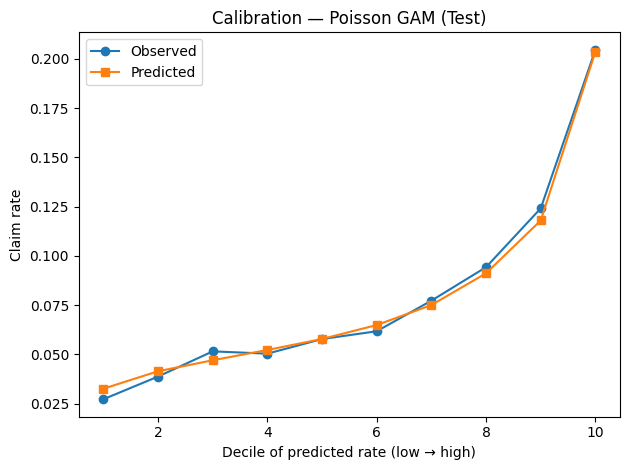

In [18]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

print(cf2("Claim Frequency GAM, Test (Actual/Predicted)",
          y_test_counts, w_test, pred_counts, w_test))
print(f"Poisson Deviance GAM, Test: {pdw(pred_counts, y_test_counts, w_test):.2f}%")

# Optional: Reliability / Dezile
pred_rate = pred_counts / w_test
dec = pd.qcut(pred_rate, q=10, duplicates="drop")
cal = (pd.DataFrame({"dec":dec, "expo":w_test, "claims":y_test_counts, "pred":pred_counts})
       .groupby("dec")
       .agg(expo=("expo","sum"), claims=("claims","sum"), pred=("pred","sum"))
       .assign(obs_rate=lambda d: d["claims"]/d["expo"],
               pred_rate=lambda d: d["pred"]/d["expo"])
       .reset_index())

plt.figure()
plt.plot(range(1, len(cal)+1), cal["obs_rate"], marker="o", label="Observed")
plt.plot(range(1, len(cal)+1), cal["pred_rate"], marker="s", label="Predicted")
plt.xlabel("Decile of predicted rate (low → high)")
plt.ylabel("Claim rate")
plt.title("Calibration — Poisson GAM (Test)")
plt.legend(); plt.tight_layout(); plt.show()


In [19]:
import pandas as pd, numpy as np

df = pd.read_parquet("../data/work/freMTPL2_joined_capped.parquet")
overall = df["ClaimNb"].sum()/df["Exposure"].sum()
print(f"Overall freq : {overall:.5f}")  # 


Overall freq : 0.07368


## GAM – Kurzfazit & Vergleich zu GLM1/GLM2

**Setup.**  
Poisson-GAM für die **Rate** $y=\frac{\text{ClaimNb}}{\text{Exposure}}$ mit **Gewichten** $w=\text{Exposure}$  
(äquivalent zu einem Offset $\log(\text{Exposure})$). Terme:
- glatt: $s(\text{VehAge}) + s(\text{DrivAge}) + s(\text{BonusMalusGLM})$
- kategorial: $f(\text{VehPowerGLM}) + f(\text{VehGas}) + f(\text{VehBrand}) + f(\text{Region})$
- linear: $l(\text{AreaGLM}) + l(\text{DensityGLM})$  
Split: 5 Folds (Seed 42), **Fold 5 = Test (~20 %)**.  
Vorhersage der Counts über $\hat\mu = \hat r \cdot \text{Exposure}$.

**Ergebnisse (Test).**
- Claim Frequency (Actual/Predicted): **7.38 % / 7.36 %**  → **Niveau-Kalibrierung passt**
- Poisson Deviance: **GAM 29.16 %**  *(besser als GLM1 **29.55 %** und GLM2 **29.52 %**; INT **31.26 %**)*

**Interpretation.**  
Die glatten Terme bilden die erwartete **U-Form** von Fahreralter sowie die **nichtlineare** Wirkung des Bonus-Malus plausibel ab. Das führt zu einer **robust besseren Güte** (PDW↓) bei unveränderter Mittelwertkalibrierung.





In [32]:
import os
PROJECT_ROOT = os.path.abspath("..")
FIG_DIR = os.path.join(PROJECT_ROOT, "figures")
os.makedirs(FIG_DIR, exist_ok=True)



<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_33674/4005618328.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = dfc.groupby('dec').apply(lambda g: pd.Series({


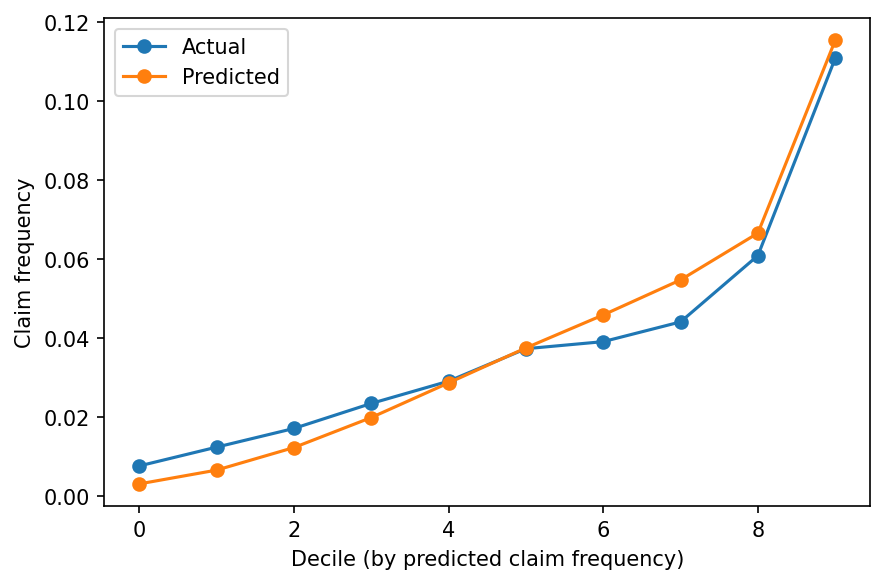

In [34]:
cal = decile_calibration(
    y_test_counts,           # Zielvariable (observed claim counts)
    test_pred_glm2,          # deine beste Schätzung, z.B. GLM2 oder GAM
    w=w_test                 # Exposure
)

plt.figure(figsize=(6,4), dpi=150)
plt.plot(cal['dec'], cal['actual'], 'o-', label='Actual')
plt.plot(cal['dec'], cal['pred'], 'o-', label='Predicted')
plt.xlabel('Decile (by predicted claim frequency)')
plt.ylabel('Claim frequency')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "calibration_glm2.png"), dpi=150, bbox_inches="tight")
plt.show()


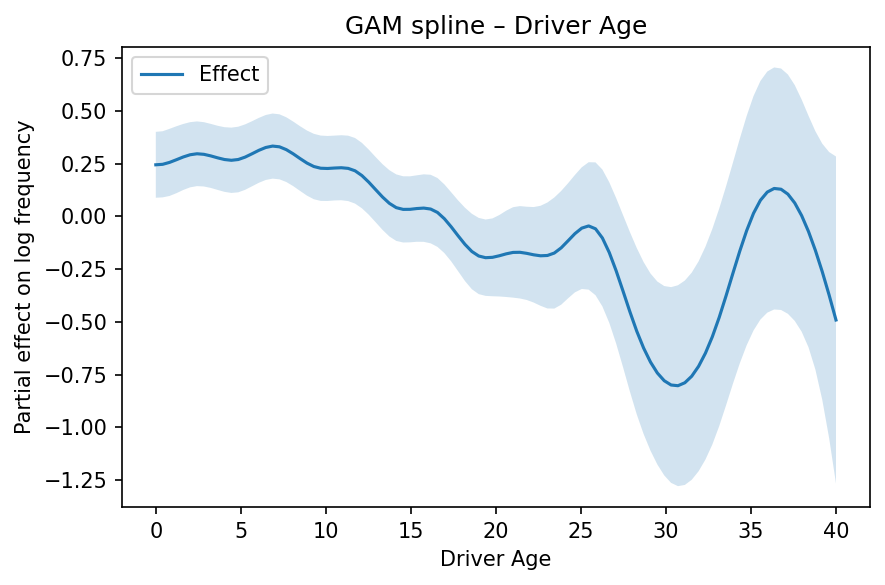

In [38]:
XX = gam.generate_X_grid(term=0)
pdep, confi = gam.partial_dependence(term=0, width=0.95)

#passt die form?
if confi.shape[0] == pdep.shape[0] and confi.shape[1] == 2:
    lower, upper = confi[:, 0], confi[:, 1]
elif confi.shape[0] == 2 and confi.shape[1] == pdep.shape[0]:
    lower, upper = confi[0], confi[1]
else:
    raise ValueError(f"Unexpected shape for confi: {confi.shape}")

plt.figure(figsize=(6,4), dpi=150)
plt.plot(XX[:, 0], pdep, label="Effect")
plt.fill_between(XX[:, 0], lower, upper, alpha=0.2)
plt.xlabel("Driver Age")
plt.ylabel("Partial effect on log frequency")
plt.title("GAM spline – Driver Age")
plt.legend(); plt.tight_layout()
plt.savefig("../figures/gam_spline_drivage.png", dpi=150, bbox_inches="tight")
plt.show()


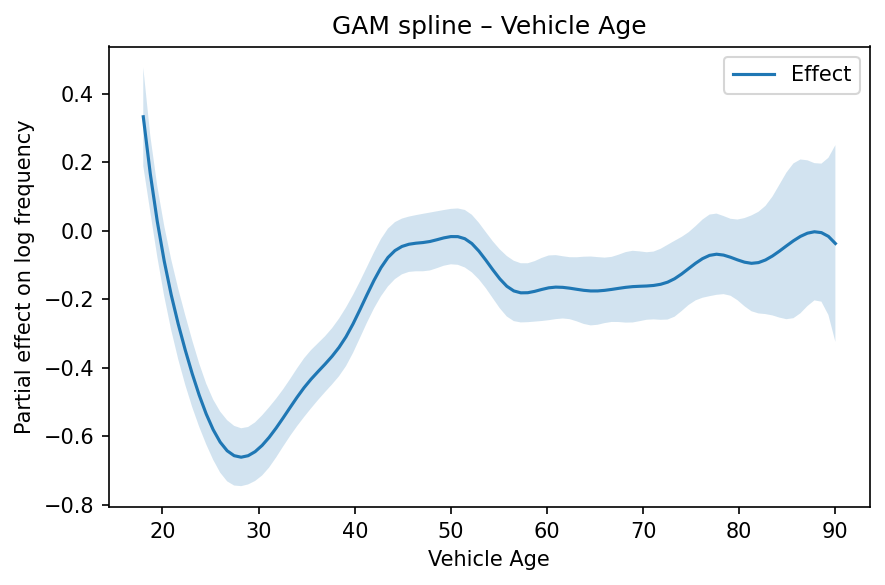

In [39]:
XX = gam.generate_X_grid(term=1)  
pdep, confi = gam.partial_dependence(term=1, width=0.95)
if confi.shape[0] == pdep.shape[0] and confi.shape[1] == 2:
    lower, upper = confi[:, 0], confi[:, 1]
else:
    lower, upper = confi[0], confi[1]

plt.figure(figsize=(6,4), dpi=150)
plt.plot(XX[:, 1], pdep, label="Effect")
plt.fill_between(XX[:, 1], lower, upper, alpha=0.2)
plt.xlabel("Vehicle Age")
plt.ylabel("Partial effect on log frequency")
plt.title("GAM spline – Vehicle Age")
plt.legend(); plt.tight_layout()
plt.savefig("../figures/gam_spline_vehage.png", dpi=150, bbox_inches="tight")
plt.show()


Gini (GLM2): 0.301
Gini (GAM):  0.299


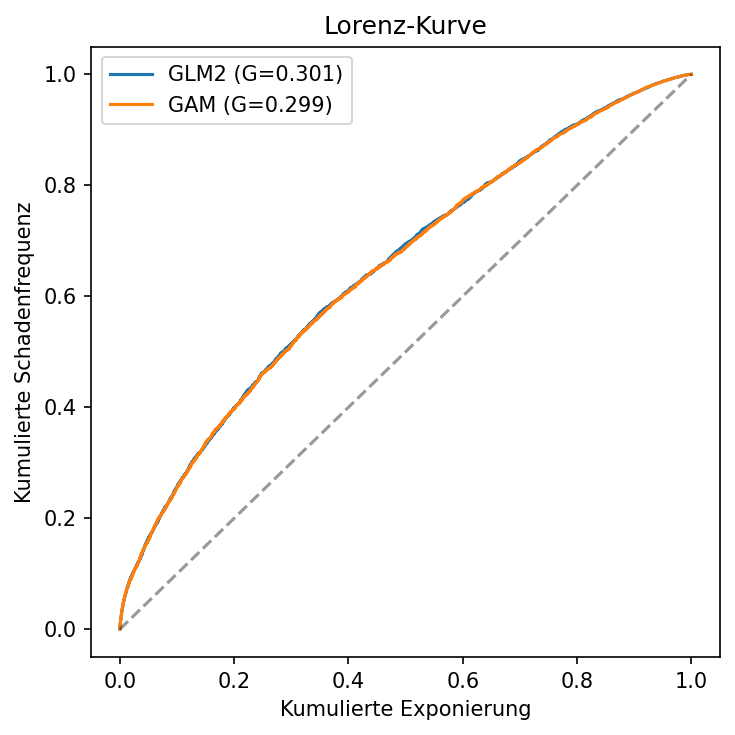

In [44]:
def gini(actual, pred, w=None):
    """Berechnet gewichteten Gini-Koeffizienten."""
    if w is None:
        w = np.ones_like(actual)
    order = np.argsort(-pred)  
    actual, w = actual[order], w[order]
    cum_actual = np.cumsum(actual * w)
    cum_weight = np.cumsum(w)
    total_actual = cum_actual[-1]
    total_weight = cum_weight[-1]
    lorenz = cum_actual / total_actual
    cum_weight = cum_weight / total_weight
    gini_coef = 2 * np.trapezoid(lorenz, cum_weight) - 1
    return gini_coef, lorenz, cum_weight


g_glm2, lor_glm2, cw = gini(y_test_counts, test_pred_glm2, w_test)
g_gam,  lor_gam,  _  = gini(y_test_counts, test_pred, w_test)

print(f"Gini (GLM2): {g_glm2:.3f}")
print(f"Gini (GAM):  {g_gam:.3f}")

# Lorenz-Plot speichern
plt.figure(figsize=(5,5), dpi=150)
plt.plot(cw, lor_glm2, label=f"GLM2 (G={g_glm2:.3f})")
plt.plot(cw, lor_gam, label=f"GAM (G={g_gam:.3f})")
plt.plot([0,1],[0,1],'k--',alpha=0.4)
plt.xlabel("Kumulierte Exponierung")
plt.ylabel("Kumulierte Schadenfrequenz")
plt.title("Lorenz-Kurve")
plt.legend(); plt.tight_layout()
plt.savefig("../figures/lorenz_glm_gam.png", dpi=150, bbox_inches="tight")
plt.show()
